In [2]:
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from typing import List, Dict

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
)
from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
%matplotlib inline

In [ ]:
from huggingface_hub import login
login("API_KEY")

In [6]:
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

GPU disponible: True
GPU: NVIDIA GeForce RTX 5090
Memoria total: 31.36 GB


In [7]:
from datasets import Dataset
import json
import numpy as np

DATA_PATH = "/datasetV3.jsonl"

raw_dataset = Dataset.from_json(DATA_PATH)
print(json.dumps(raw_dataset[0], indent=2, ensure_ascii=False))


def analyze_dataset(dataset):
    stats = {
        "total_examples": len(dataset),
        "prompt_lengths": [],
        "response_lengths": [],
    }

    for example in dataset:
        prompt = example["prompt"]
        response = example["response"]

        stats["prompt_lengths"].append(len(prompt.split()))
        stats["response_lengths"].append(len(response.split()))

    return stats


stats = analyze_dataset(raw_dataset)

print(f"Total ejemplos: {stats['total_examples']}")
print(f"Longitud promedio prompt de palabras: {np.mean(stats['prompt_lengths']):.2f}")
print(f"Longitud promedio response de palabras: {np.mean(stats['response_lengths']):.2f}")


{
  "prompt": "¿Qué hago si tengo problemas para conciliar el sueño?",
  "response": "sumercérito, evite pantallas un ratico antes de dormir y tome algo caliente. Si le pasa muy seguido, consulte con un médico. No dé papaya que el sueño es clave pa todo."
}
Total ejemplos: 9294
Longitud promedio prompt de palabras: 7.20
Longitud promedio response de palabras: 24.78


/tmp/ipykernel_2098/3068489553.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([prompt_lengths, response_lengths], labels=['Prompt', 'Response'])


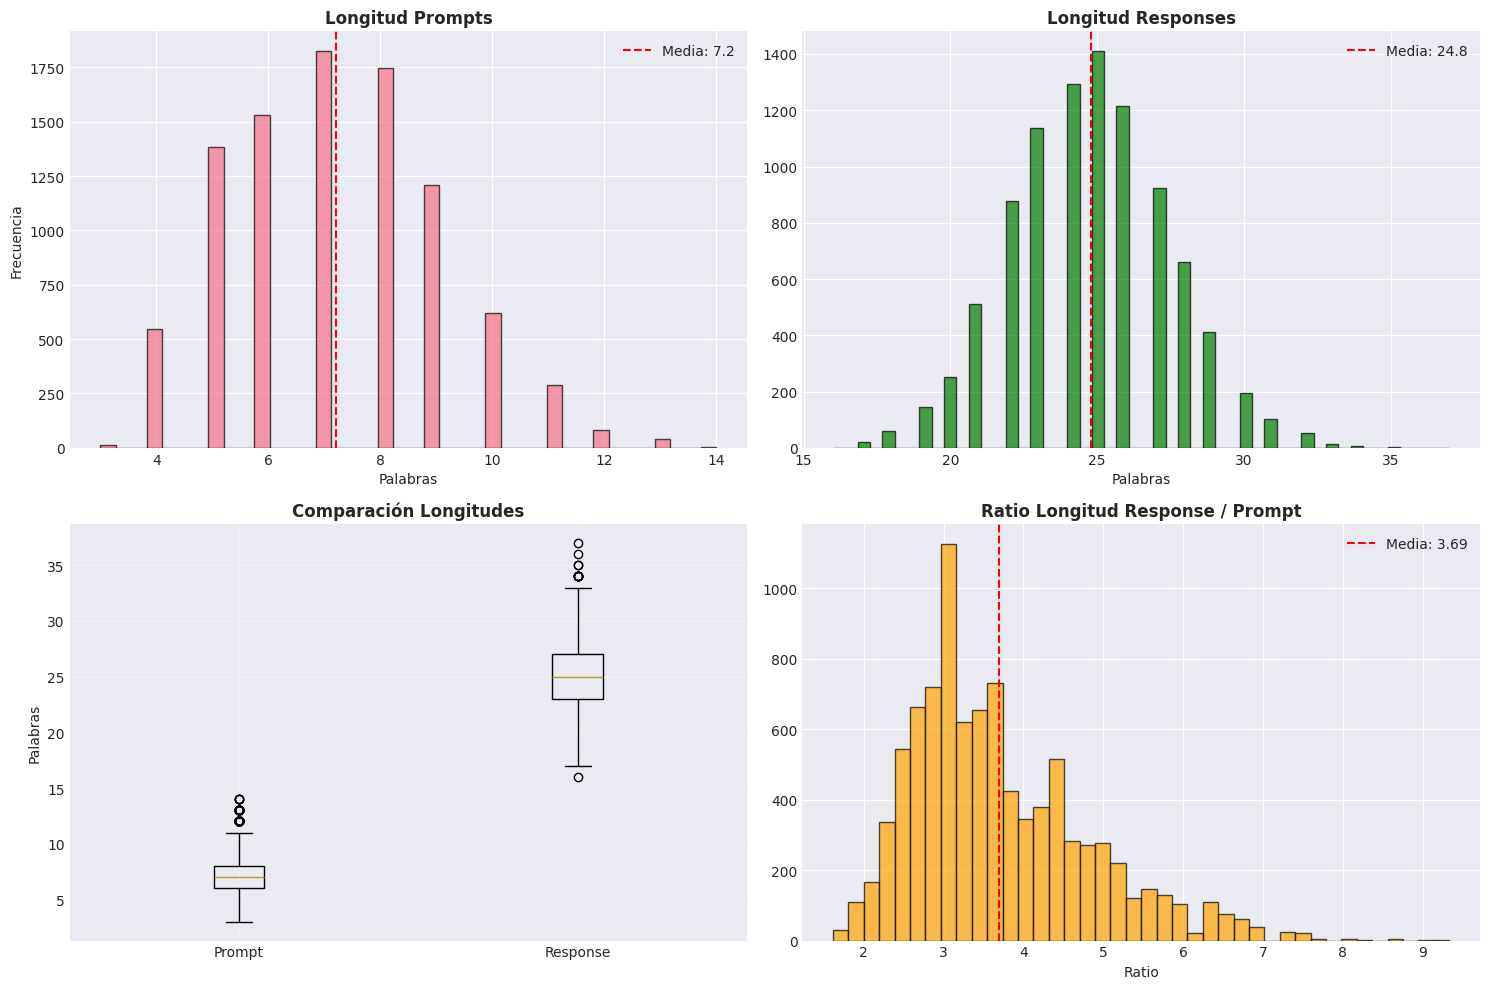

Prompts - Media: 7.20, Mediana: 7
Responses - Media: 24.78, Mediana: 25
Ejemplos válidos: 9294


In [8]:
import numpy as np
import matplotlib.pyplot as plt

prompts = [ex["prompt"] for ex in raw_dataset if ex["prompt"] is not None]
responses = [ex["response"] for ex in raw_dataset if ex["response"] is not None]

prompt_lengths = [len(text.split()) for text in prompts]
response_lengths = [len(text.split()) for text in responses]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma longitud prompts
axes[0, 0].hist(prompt_lengths, bins=40, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Longitud Prompts', fontweight='bold')
axes[0, 0].set_xlabel('Palabras')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(np.mean(prompt_lengths), color='red', linestyle='--',
                   label=f'Media: {np.mean(prompt_lengths):.1f}')
axes[0, 0].legend()

# Histograma longitud responses
axes[0, 1].hist(response_lengths, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Longitud Responses', fontweight='bold')
axes[0, 1].set_xlabel('Palabras')
axes[0, 1].axvline(np.mean(response_lengths), color='red', linestyle='--',
                   label=f'Media: {np.mean(response_lengths):.1f}')
axes[0, 1].legend()

# Boxplot comparativo
axes[1, 0].boxplot([prompt_lengths, response_lengths], labels=['Prompt', 'Response'])
axes[1, 0].set_title('Comparación Longitudes', fontweight='bold')
axes[1, 0].set_ylabel('Palabras')
axes[1, 0].grid(True, alpha=0.3)

# Distribución ratio response/prompt
ratios = [r/p if p > 0 else 0 for r, p in zip(response_lengths, prompt_lengths)]
axes[1, 1].hist(ratios, bins=40, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Ratio Longitud Response / Prompt', fontweight='bold')
axes[1, 1].set_xlabel('Ratio')
axes[1, 1].axvline(np.mean(ratios), color='red', linestyle='--',
                   label=f'Media: {np.mean(ratios):.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Prompts - Media: {np.mean(prompt_lengths):.2f}, Mediana: {np.median(prompt_lengths):.0f}")
print(f"Responses - Media: {np.mean(response_lengths):.2f}, Mediana: {np.median(response_lengths):.0f}")
print(f"Ejemplos válidos: {len(prompt_lengths)}")


  'parce': 3009 veces
  'pues': 2853 veces
  'mijo': 2403 veces
  'vea': 2261 veces
  'sumercé': 910 veces
  'listo': 569 veces
  'berraco': 201 veces
  'qué más': 28 veces
  'chévere': 20 veces
  'todo bien': 13 veces
  'mija': 3 veces

Top de palabras más frecuentes:
  parce: 3009
  pues: 2853
  mijo: 2403
  hágale: 1998
  bien: 1686
  pilas: 1663
  mejor: 1233
  poquito: 1214


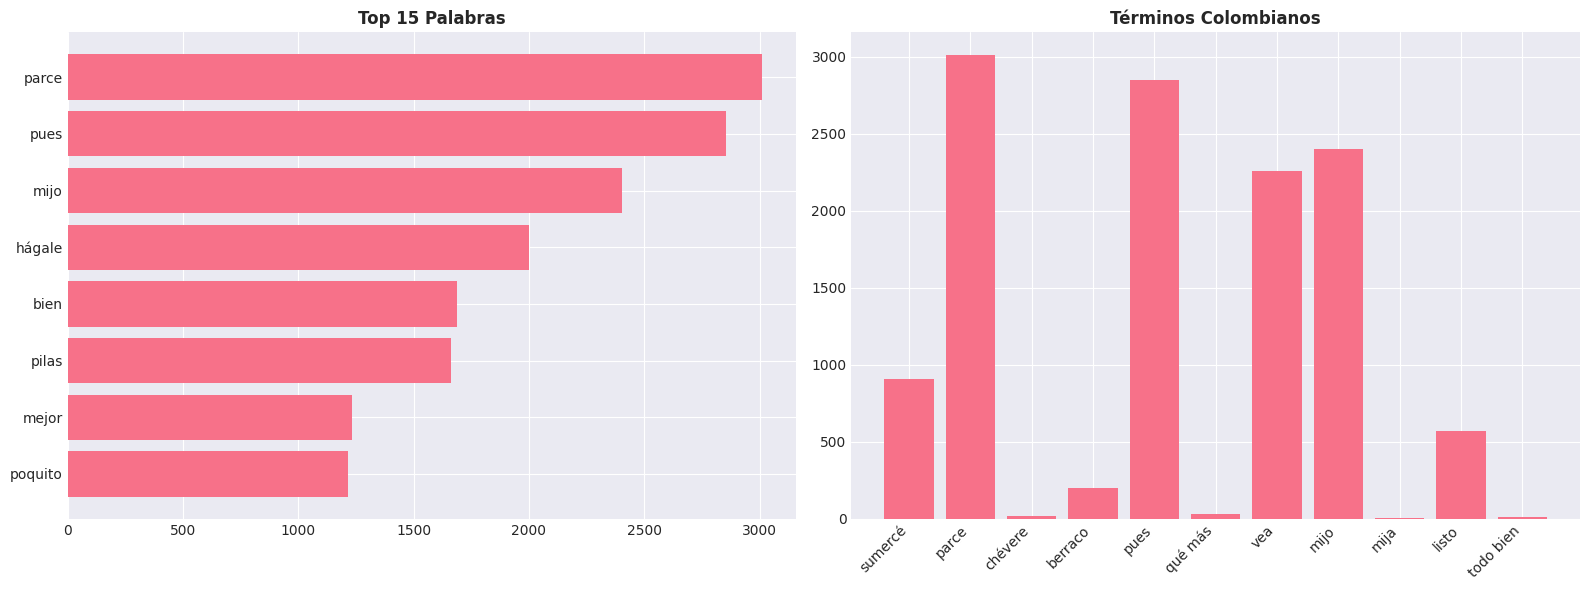

In [9]:
import re
from collections import Counter
import matplotlib.pyplot as plt

responses = [ex["response"] for ex in raw_dataset if ex["response"] is not None]
def extract_colombian_terms(texts):
    patterns = [
        r'\bsumercé\b', r'\bparce\b', r'\bchévere\b', r'\bberraco\b',
        r'\bpues\b', r'\bqué más\b', r'\bvea\b', r'\bmijo\b', r'\bmija\b',
        r'\blisto\b', r'\btodo bien\b', r'\ba la orden\b'
    ]
    
    all_text = ' '.join(texts).lower()
    colombian_counts = {}
    
    for pattern in patterns:
        matches = re.findall(pattern, all_text)
        if matches:
            term = pattern.replace(r'\b', '')
            colombian_counts[term] = len(matches)
    
    return colombian_counts


all_text = ' '.join(responses).lower()
words = re.findall(r'\b\w+\b', all_text)
word_freq = [(word, count) 
             for word, count in Counter(words).most_common(30) 
             if len(word) >= 4]

colombian_terms = extract_colombian_terms(responses)
for term, count in sorted(colombian_terms.items(), key=lambda x: x[1], reverse=True):
    print(f"  '{term}': {count} veces")

print("\nTop de palabras más frecuentes:")
for word, count in word_freq[:20]:
    print(f"  {word}: {count}")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
words_list, counts_list = zip(*word_freq[:15])
axes[0].barh(range(len(words_list)), counts_list)
axes[0].set_yticks(range(len(words_list)))
axes[0].set_yticklabels(words_list)
axes[0].set_title('Top 15 Palabras', fontweight='bold')
axes[0].invert_yaxis()

if colombian_terms:
    col_terms = list(colombian_terms.keys())
    col_counts = list(colombian_terms.values())
    
    axes[1].bar(range(len(col_terms)), col_counts)
    axes[1].set_xticks(range(len(col_terms)))
    axes[1].set_xticklabels(col_terms, rotation=45, ha='right')
    axes[1].set_title('Términos Colombianos', fontweight='bold')


plt.tight_layout()
plt.show()

In [10]:
from typing import Dict

SYSTEM_PROMPT = (
    "Eres un asistente colombiano amigable y cercano. "
    "Hablas con palabras y expresiones típicas de Colombia"
    "Tu tono es 100% colombiano y coloquial"
)

def format_example_for_training(example: Dict) -> str:
    return (
        "<|start_header_id|>system<|end_header_id|>\n\n"
        f"{SYSTEM_PROMPT}<|eot_id|>"
        "<|start_header_id|>user<|end_header_id|>\n\n"
        f"{example['prompt']}<|eot_id|>"
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
        f"{example['response']}<|eot_id|>"
    )


def process_dataset(example):
    return {"text": format_example_for_training(example)}


formatted_dataset = raw_dataset.map(
    process_dataset,
    remove_columns=raw_dataset.column_names
)

print(f"Formateado: {len(formatted_dataset)} ejemplos")
print("\nEjemplo:")
print(formatted_dataset[0]['text'][:400] + "...")


Map:   0%|          | 0/9294 [00:00<?, ? examples/s]

Formateado: 9294 ejemplos

Ejemplo:
<|start_header_id|>system<|end_header_id|>

Eres un asistente colombiano amigable y cercano. Hablas con palabras y expresiones típicas de ColombiaTu tono es 100% colombiano y coloquial<|eot_id|><|start_header_id|>user<|end_header_id|>

¿Qué hago si tengo problemas para conciliar el sueño?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

sumercérito, evite pantallas un ratico antes de dormir...


In [11]:
train_test = formatted_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_test['test'].train_test_split(test_size=0.5, seed=SEED)

dataset_dict = DatasetDict({
    'train': train_test['train'],
    'validation': test_val['train'],
    'test': test_val['test']
})

print(f"Train: {len(dataset_dict['train'])}")
print(f"Validation: {len(dataset_dict['validation'])}")
print(f"Test: {len(dataset_dict['test'])}")

Train: 7435
Validation: 929
Test: 930


In [12]:
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

In [13]:
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)


model = get_peft_model(model, lora_config)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Entrenables: {trainable:,}")
print(f"Total: {total:,}")
print(f"Porcentaje: {100 * trainable / total:.2f}%")

Entrenables: 27,262,976
Total: 8,057,524,224
Porcentaje: 0.34%


In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

OUTPUT_DIR = "/llama_colombiano_checkpoints"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.15,
    logging_steps=10,
    save_strategy="epoch",
    eval_strategy="epoch",
    fp16=False,
    bf16=True,
    tf32=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    weight_decay=0.01,
    seed=SEED,
)

print(f"Épocas: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch efectivo: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Épocas: 4
Batch size: 8
Gradient accumulation: 4
Learning rate: 5e-05
Batch efectivo: 32


In [15]:
def formatting_func(example):
    return example["text"]

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    processing_class=tokenizer,
    formatting_func=formatting_func,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.005)],
)

trainer.create_model_card = lambda *args, **kwargs: None


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Applying formatting function to train dataset:   0%|          | 0/7435 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/7435 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/7435 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7435 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/929 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/929 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/929 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/929 [00:00<?, ? examples/s]

In [16]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,0.758168,0.766554
2,0.674474,0.682817
3,0.617012,0.646195
4,0.602124,0.642977


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during

TrainOutput(global_step=932, training_loss=0.8637109957795286, metrics={'train_runtime': 2271.9867, 'train_samples_per_second': 13.09, 'train_steps_per_second': 0.41, 'total_flos': 1.5862723916311757e+17, 'train_loss': 0.8637109957795286})

In [17]:
model.print_trainable_parameters()

trainable params: 27,262,976 || all params: 8,057,524,224 || trainable%: 0.3384


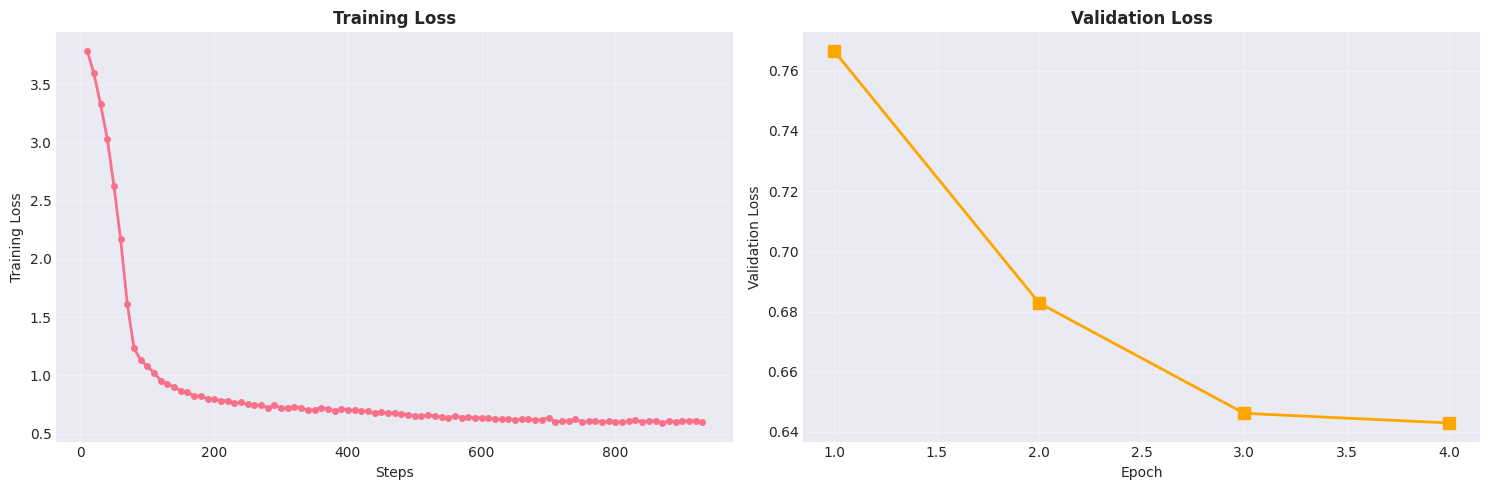

Train loss: 0.6021
Val loss: 0.6430
Mejor val loss: 0.6430


In [18]:
log_history = trainer.state.log_history

train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if train_logs:
    steps = [log['step'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0].plot(steps, losses, marker='o', linewidth=2, markersize=4)
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

if eval_logs:
    epochs = [log['epoch'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    axes[1].plot(epochs, eval_losses, marker='s', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_title('Validation Loss', fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if eval_logs:
    print(f"Train loss: {train_logs[-1]['loss']:.4f}")
    print(f"Val loss: {eval_logs[-1]['eval_loss']:.4f}")
    print(f"Mejor val loss: {min(log['eval_loss'] for log in eval_logs):.4f}")

In [22]:
SYSTEM_PROMPT = (
    "Eres un asistente colombiano amigable y cercano. "
    "Hablas con palabras y expresiones típicas de Colombia"
    "Tu tono es 100% colombiano y coloquial"
)

def generate_response(user_message: str, max_new_tokens: int = 150) -> str:
    prompt = f"""<|start_header_id|>system<|end_header_id|>

{SYSTEM_PROMPT}<|eot_id|><|start_header_id|>user<|end_header_id|>

{user_message}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

"""
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response.strip()

In [23]:
test_prompts = [
    "Hola",
    "Me interesa pero está muy caro",
    "¿Qué tal la calidad del producto que vendes?",
    "No estoy seguro",
    "Muchas gracias",
    "Buenos dias"
]


for i, prompt in enumerate(test_prompts, 1):
    print(f"\n[{i}] User: {prompt}")
    response = generate_response(prompt)
    print(f"Assistant: {response}")
    print("-"*80)


[1] User: Hola
Assistant: me alegra que esté aquí. ¿en qué lo traemos? Hable pues, sin miedo.
--------------------------------------------------------------------------------

[2] User: Me interesa pero está muy caro
Assistant: Mano, vea más a fondo el precio antes de tomar una decisión. A veces hay opciones más economicas que no se conocen. Hágale pues.
--------------------------------------------------------------------------------

[3] User: ¿Qué tal la calidad del producto que vendes?
Assistant: Vea le cuento, la calidad siempre se nota, parce. Si su producto es bueno, no tiene que vender con mucho estruendo. De una, hágale con orgullo.
--------------------------------------------------------------------------------

[4] User: No estoy seguro
Assistant: A lo bien, mijo, si no entiende algo pregúntele. No se quede callado y confundido. Parce, el aprendizaje es una chimba.
--------------------------------------------------------------------------------

[5] User: Muchas gracias
Assi

In [21]:
FINAL_MODEL_PATH = "/llama_colombiano_LoRA"

trainer.model.save_pretrained(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

('/llama_colombiano_LoRA/tokenizer_config.json',
 '/llama_colombiano_LoRA/chat_template.jinja',
 '/llama_colombiano_LoRA/tokenizer.json')